In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd

(7179, 30)
Index(['mut_id', 'md5', 'pmd_id', 'nr', 'prot_acc_version', 'snp_id',
       'mut_real', 'wt', 'mut', 'prot_pos', 'chrom', 'chrom_pos', 'ref_allele',
       'alt_allele', 'function', 'source', 'crossref', 'function_summarized',
       'class', 'SIFT_score', 'Polyphen2_HVAR_score', 'MetaRNN_score',
       'REVEL_score', 'MVP_score', 'CADD_raw_score',
       'integrated_fitCons_score', 'phyloP17way_primate_score',
       'phastCons17way_primate_score', 'bStatistic_score', 'pred'],
      dtype='object')


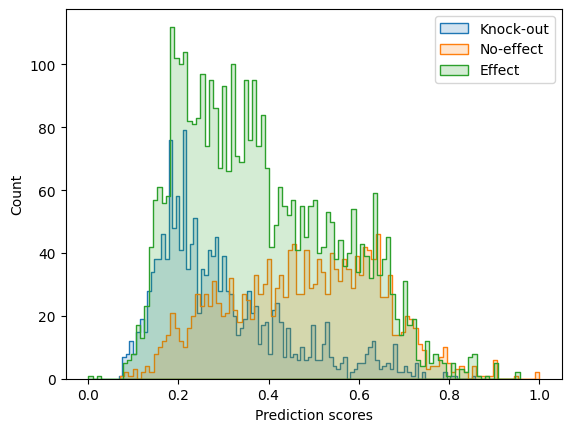

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(result_df, n_samples=None):
    df = result_df.copy(deep=True)
    plt.cla()

    effect = df[df["class"]=="Effect"]
    knock_out = df[df["class"]=="Knock-out"]
    no_effect = df[df["class"]=="No-effect"]

    if n_samples is not None:
        effect = effect.sample(n=n_samples)
        knock_out = knock_out.sample(n=n_samples)
        no_effect = no_effect.sample(n=n_samples)

    # print(effect.shape, knock_out.shape, no_effect.shape)
    bins = 100 # 20, 100, 500
    
    sns.histplot(knock_out["pred"], bins=bins, label=f"Knock-out", element="step", alpha=.2)
    sns.histplot(no_effect["pred"], bins=bins, label=f"No-effect", element="step", alpha=.2)
    sns.histplot(effect["pred"], bins=bins, label=f"Effect", element="step", alpha=.2)
    # sns.histplot(result_df, x="pred", y="class", element="step", hue="class", bins=bins, alpha=0.2)
    
    plt.legend()
    plt.xlabel("Prediction scores")
    plt.ylabel("Count")
    plt.show()

result_df = pd.read_csv(home_dir+f"models/vespa_marquet/outputs/vespa/pmd/preds_vespa_masked.tsv", sep="\t")
# result_df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
model_pred_col = "pred"
result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
# result_df["pred"]=result_df[model_pred_col]
print(result_df.shape)
print(result_df.columns)
result_df["class"].value_counts()
plot_distribution(result_df, n_samples=None)

In [9]:
# does masking change the logits: yes.
# loading logits from from same seq but masked in different position.
import utils.pickle_utils as pickle_utils
logits_1 = pickle_utils.load_pickle(home_dir+f"models/vespa_marquet/outputs/vespa/lm_outputs/A000006_2_271.pkl") 
logits_2 = pickle_utils.load_pickle(home_dir+f"models/vespa_marquet/outputs/vespa/lm_outputs/A000006_2_62.pkl") 
print(logits_1.shape, logits_2.shape)
# now see, logits in masked position are different, 
print(logits_1[270])
print(logits_2[270])
# but non-masked position are same.
# print(logits_1[1])
# print(logits_2[1])

(333, 128) (333, 128)
[-18.4878    -22.949091  -38.26504    -7.300834   -6.658306   -7.0187225
  -7.0971704  -5.225935   -6.947036   -8.462962   -7.6526833  -6.9689527
  -7.2655077  -8.009003   -8.329077   -5.4901075  -7.926539   -6.5617867
  -5.6144943  -7.9192348  -7.335067   -6.939086    0.9607053  -9.994657
 -38.907906  -38.88283   -38.507957  -38.34755   -38.25691   -38.697487
 -38.068604  -38.78185   -38.315678  -38.91271   -38.62858   -39.077114
 -38.514313  -38.23457   -38.610947  -38.90276   -37.73464   -38.958107
 -38.64975   -38.593254  -37.579292  -38.18425   -38.490196  -37.573486
 -38.19103   -38.179268  -38.261032  -38.80136   -38.286304  -37.806274
 -38.77648   -38.126602  -37.6558    -38.057735  -38.742058  -37.88672
 -38.151596  -37.99424   -38.314735  -38.346714  -37.75525   -38.61832
 -37.549538  -38.103226  -38.064907  -38.97631   -38.82532   -38.775043
 -38.872723  -38.65758   -38.139046  -37.507587  -38.24138   -38.8613
 -38.193134  -38.623577  -38.581158  -38.87

In [2]:
from vespa.predict.logodds import *
import vespa.predict.utils as vespa_utils

/projects/ashehu/akabir4/venvs/hopper_vespa_marquet_from_source/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [3]:
cache_dir=home_dir+"models/vespa_marquet/cache"
t5_condProbas = T5_condProbas(cache_dir=cache_dir)
model, tokenizer = t5_condProbas.prott5.get_model(1) #1=LOGODDS
model.to("cpu")

In [5]:
tokenizer

T5Tokenizer(name_or_path='Rostlab/prot_t5_xl_uniref50', vocab_size=128, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '

In [6]:
import re
seq = "ASDX"
seq = re.sub(r"[UZOB]", "X", seq) # replacing unknown amino acids 
seq = list(seq)
seq[2] = "<extra_id_0>" # mut_pos should be 0-indexed. replace AA by special mask token used by T5
seq = " ".join(seq)
input_ids = tokenizer(seq, return_tensors="pt").input_ids.to("cpu")
print(input_ids)
with torch.no_grad():  # only logits is useful for us
    logits = model(input_ids, labels=input_ids).logits
    logits = logits[0].detach().numpy() 

print(logits.shape)
logits

tensor([[  3,   7, 127,  23,   1]])
(5, 128)


array([[-2.91068115e+01, -5.45365448e+01, -7.43222656e+01,
        -2.02146411e+00, -2.19304924e+01, -1.98203201e+01,
        -2.22698174e+01, -2.00179672e+01, -2.14014206e+01,
        -2.21622543e+01, -2.11345768e+01, -2.14733925e+01,
        -2.40762138e+01, -2.05142231e+01, -2.18514900e+01,
        -2.42242603e+01, -2.24806061e+01, -2.35430584e+01,
        -2.35312500e+01, -2.45066071e+01, -2.52229252e+01,
        -2.41816750e+01, -2.13377533e+01, -2.55332565e+01,
        -7.47518234e+01, -7.44212494e+01, -7.50349884e+01,
        -7.47520218e+01, -7.39672470e+01, -7.48720551e+01,
        -7.42906189e+01, -7.42783508e+01, -7.42578201e+01,
        -7.53950958e+01, -7.42682495e+01, -7.47694397e+01,
        -7.53383789e+01, -7.42927399e+01, -7.40554199e+01,
        -7.51404114e+01, -7.35035400e+01, -7.51246033e+01,
        -7.51932297e+01, -7.48868179e+01, -7.43903046e+01,
        -7.51347809e+01, -7.44550018e+01, -7.40901337e+01,
        -7.35273819e+01, -7.46163559e+01, -7.46038208e+0

In [7]:
tokenizer.convert_tokens_to_ids("▁V")

6

In [9]:
from pathlib import Path
seq_dict = vespa_utils.parse_fasta_input(Path(home_dir+"models/aa_common/datasets_pmd_analysis/pmd_sequences.fasta")) # this replaces the unknown amino acids UZO, not B
print(len(seq_dict))
protid_seq_dict_list = [(prot_id, seq) for prot_id, seq in  seq_dict.items()]
protid, seq = protid_seq_dict_list[0]
seq

11714


'MVNSTHRGMHTSLHLWNRSSYRLHSNASESLGKGYSDGGCYEQLFVSPEVFVTLGVISLLENILVIVAIAKNKNLHSPMYFFICSLAVADMLVSVSNGSETIVITLLNSTDTDAQSFTVNIDNVIDSVICSSLLASICSLLSIAVDRYFTIFYALQYHNIMTVKRVGIIISCIWAACTVSGILFIIYSDSSAVIICLITMFFTMLALMASLYVHMFLMARLHIKRIAVLPGTGAIRQGANMKGAITLTILIGVFVVCWAPFFLHLIFYISCPQNPYCVCFMSHFNLYLILIMCNSIIDPLIYALRSQELRKTFKEIICCYPLGGLCDLSSRY'

In [17]:
a_prot_seq = protid_seq_dict_list[0]
csv_dir = home_dir+"models/vespa_marquet/outputs/vespa/lm_outputs"
mutation_gen = vespa_utils.MutationGenerator(sequence_dict=a_prot_seq)
proba_dict = t5_condProbas.get_proba_dict(a_prot_seq, mutation_gen)
dmiss_data = t5_condProbas.get_log_odds(proba_dict)
T5_condProbas.write_csv_dir(dmiss_data, csv_dir, mutation_gen)

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 14.76 GiB total capacity; 9.02 GiB already allocated; 17.75 MiB free; 9.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
import re
seq = "CUDA"
re.sub(r"[UZOB]", "X", seq)

'CXDA'

In [ ]:
import vespa.predict.utils as vespa_utils
from pathlib import Path
seq_dict = vespa_utils.parse_fasta_input(Path(home_dir+"models/aa_common/datasets_pmd_analysis/pmd_sequences.fasta"))
print(len(seq_dict))
# protid_seq_dict_list = [{prot_id: seq} for prot_id, seq in  seq_dict.items()]
protid_seq_dict_list = [(prot_id, seq) for prot_id, seq in  seq_dict.items()]
protid, seq = protid_seq_dict_list[0]
print(protid, seq)